In [104]:
import numpy as np
import scipy as sp 
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm

## Constants 
hbar = 1.05*(10**(-34))
pi = 3.14159 
c = 3*(10**(8))
kb = 8.617*(10**(-5))
kb_SI = 1.38*(10**(-23))
qe = 1.6*(10**(-19)) 
eps0 = 8.85*(10**(-12))  
m0 = 9*(10**(-31)) 
a_lat = 3.1*(10**(-10)) 
eV2meter = 1.97*(10**(-7)) ##in meter
eV2sec = 6.58*(10**(-16))
eV2mass = 1.78*(10**(-36))


# Transport physics 
def get_fermi_circle(k_rad, nk, nthet):##ok 
    ##Input: radius of 2D Fermi circle (float), size of k array (int), size of theta array (int)
    ##Output: grid of k points in Fermi circle (array)
    kx_list = []
    ky_list = []
    k_range = np.linspace(0 ,k_rad, int(nk))
    thet_range = np.linspace(0, 2*pi, int(nthet))  
    for i in range(0,nk):
        for j in range(0,nthet): 
            kx_list.append(k_range[i]*np.cos(thet_range[j]))
            ky_list.append(k_range[i]*np.sin(thet_range[j]))
    return [np.asarray(kx_list), np.asarray(ky_list)]  

#def get_2DEG_density(Vg, del_Ec, eps, d_del, ): 
    

def get_bose_distribution(energy, T):## ok 
    return (np.exp(energy/(kb_SI*T))-1)**(-1)    

#def get_fermi_level( ):

#def get_fermi_vector( ): 



def get_conduction_band(Ec, mstar, k_vec): ##ok 
    ##Input: Conduction band offset (float), effective mass (float), k_point to evaluate at (array)
    ##Output: kmesh (array), conduction band (array)
    Ek = lambda Ec, mstar, kx, ky: Ec + ((hbar**2)/(2*mstar*m0))*(kx**(2) + ky**(2)) 
    return Ek(Ec, mstar, k_vec[0], k_vec[1]) 

def get_group_velocity(mstar, kvec): ##ok 
    ##Input: Conduction band offset (float), effective mass (float),  k_point to evaluate at (array)
    ##Output: kmesh (array), conduction band (array)
    vg = lambda mstar, kvec: [((hbar**(2))/(mstar*m0))*kvec[0], ((hbar**(2))/(mstar*m0))*kvec[1]]
    return np.asarray(vg(mstar, k_vec)) 

## runMC requires input: specify k mesh, number of electrons, preferred start, and applied field
def evolvek_h(del_t, E_field, k0): ##ok 
    del_k = (qe*del_t*E_field)/hbar 
    return k0 + del_k

def compute_rate_prob_AP(k0, kf, mstar, vs, T):  
    ##Computes probability of transition from k0 to kf at temperature T for acoustic phonon scattering
    ##Input: inital k state k0 [m**(-1)] final k state kf [m**(-1)], effective mass mstar [m0], sound velocity vs [m/s], temperature T[K]
    ##Output: pseudo-probability of transition 
    
    E0 = get_conduction_band(0, mstar, k0) 
    Ef = get_conduction_band(0, mstar, kf) 
    delE = Ef-E0

    q = np.linalg.norm(k0-kf)
    energ_ph  = hbar*q*vs 
    nq = get_bose_distribution(energ_ph, T)
    
    if(delE > 0): 
        prob = (q*nq)/(0.2*energ_ph)  
        
    elif(delE < 0):
        prob = (q*(nq+1))/(0.2*energ_ph) 
    
    else: 
        prob = 0   
 
    return prob 

def compute_rate_prob_POP(k0, kf, mstar, energ_ph,T):  
    ##Computes probability of transition from k0 to kf at temperature 
    ##Input: inital k state k0  [m**(-1)], final k state kf  [m**(-1)],  effective mass mstar [m0], energy of polar optical phonon [eV] 
    ##Output: pseudo-probability of transition
    
    E0 = get_conduction_band(0, mstar, k0) 
    Ef = get_conduction_band(0, mstar, kf) 
    delE = (Ef-E0)*(1/qe)
    q = np.linalg.norm(k0-kf)
    nq = get_bose_distribution(energ_ph*qe, T)

    if(abs(delE) < energ_ph):
        if(delE > 0): 
            prob = ((q**2)*nq)/(0.2*energ_ph)  
                
        elif(delE < 0):
            prob = ((q**2)*(nq+1))
        else: 
            prob = 0  
    else: 
        prob = 0 
    
    return prob 
 

def scatter_prob_h(k0, kmesh, mstar, T, phonon_typ, vs = 0, energ_POP = 0):
    ##Computes transition probability matrix at temeprature T
    ##Input: inital k state k0  [m**(-1)], kmesh  [m**(-1)],  effective mass mstar [m0], temperature [K], phonon type [1 if acoustic, 0 if POP], energy of polar optical phonon [eV] 
    ##Output: pseudo-probability of transition
    assert phonon_typ == 1 or phonon_typ == 0, "phonon_typ should be 1 or 0"
    if(phonon_typ == 1): 
        prob_fun = lambda k0, kf: compute_rate_prob_AP(k0, kf, mstar, vs, T)    
    else: 
        prob_fun = lambda k0, kf: compute_rate_prob_POP(k0, kf, mstar, energ_POP,T)            

    rate_list = np.array([prob_fun(k0, np.array([kmesh[0][i], kmesh[1][i]])) for i in range(len(kmesh[0]))])
    rate_list_not_nan = [] 
    kx_list_not_nan = [] 
    ky_list_not_nan = [] 
    for i in range(len(rate_list)):
        if(np.isnan(rate_list[i]) == False):
            rate_list_not_nan.append(rate_list[i])
            kx_list_not_nan.append(kmesh[0][i])
            ky_list_not_nan.append(kmesh[1][i])   
    
    return [np.array(kx_list_not_nan), np.array(ky_list_not_nan), np.array(rate_list_not_nan)/np.sum(np.array(rate_list_not_nan))]
 

In [105]:
a_lat = 3.0*10**(-9)
del_t = 10**(-15)
k_pts_test = get_fermi_circle(2*pi/a_lat, 100, 100)
k_evolv_x =  [] 
k_evolv_y =  [] 
E_field = np.array([10**(7), 0])
k0 = np.array([0,0])

for i in range(0,100): 
    kf = evolvek_h(del_t, E_field, k0)
    k_evolv_x.append(kf[0])
    k_evolv_y.append(kf[1])
    k0 = kf 
k_evolv = [k_evolv_x, k_evolv_y]

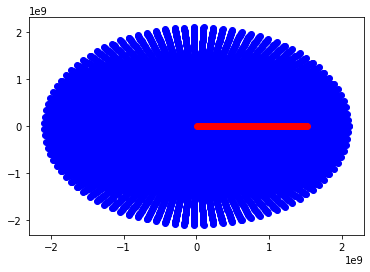

In [106]:
fig = plt.figure()
plt.scatter(k_pts_test[0], k_pts_test[1],c="b")
plt.scatter(k_evolv[0], k_evolv[1],c="r")

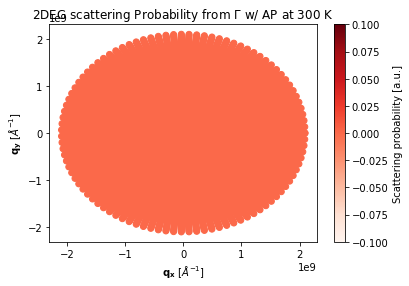

In [107]:
cgrid = plt.cm.get_cmap('Reds')
fig4 = plt.figure()
sc = plt.scatter(prob[0], prob[1], c=prob[2],vmin=0, vmax= np.max(prob[2]), cmap=cgrid)
plt.colorbar(sc, label = 'Scattering probability [a.u.]')
plt.title("2DEG scattering Probability from $\Gamma$ w/ AP at 300 K")
plt.xlabel("$\mathbf{q_{x}}$ $[\AA^{-1}]$")
plt.ylabel("$\mathbf{q_{y}} $ $[\AA^{-1}]$")
plt.show()

In [102]:
tst_pop = scatterPOP_prob_h(np.array([0,0]), k_pts_test, 0.2, 0.2)
sc = plt.scatter(tst_pop[0], tst_pop[1], c=tst_pop[2],vmin=0, vmax= np.max(tst_pop[2]),s =len(tst_pop[2]), cmap=cgrid)
plt.colorbar(sc, label = 'Scattering probability [a.u.]')
plt.title("2DEG scattering Probability from $\Gamma$ w/ POP at 300 K")
plt.xlabel("$\mathbf{q_{x}}$ $[\AA^{-1}]$")
plt.ylabel("$\mathbf{q_{y}} $ $[\AA^{-1}]$")
plt.show()

NameError: name 'scatterPOP_prob_h' is not defined

In [63]:
np.max(prob[2])

0.002772485967125992

In [5]:
a = 1 
assert a == 1 or a == 0, "x should be 2"

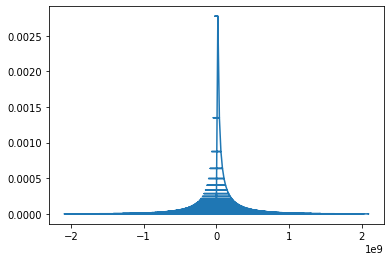

In [71]:
plt.plot(prob[0],prob[2])